In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, cross_validation, svm
import matplotlib.pyplot as plt
from matplotlib import style


#boxrec.com scraped data

df = pd.read_csv('/Users/chrisosufsen/Downloads/bouts_out_new2.csv')
df = df.drop(['judge1_A','judge1_B','judge2_A','judge2_B','judge3_A','judge3_B'], 1)
df.replace('?', -99999, inplace = True) #DO THIS?

df.describe()

/Users/chrisosufsen/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/chrisosufsen/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,age_A,age_B,height_A,height_B,reach_A,reach_B,weight_A,weight_B,won_A,won_B,lost_A,lost_B,drawn_A,drawn_B,kos_A,kos_B
count,352888.000000,257935.000000,249246.000000,134640.000000,112342.000000,37873.000000,135573.000000,130358.000000,387427.000000,387427.000000,387427.000000,387427.000000,387427.000000,387427.000000,387427.000000,387348.000000
mean,24.416041,26.583345,172.786657,172.882657,178.848605,179.001030,146.340636,147.089484,23.108438,15.159080,5.484135,8.610487,2.826481,2.636375,10.338887,6.234735
std,6.523590,11.823224,9.130127,9.430631,12.002404,14.867537,30.240142,30.624890,27.629901,19.938137,8.775672,12.783084,5.584610,5.027003,12.392049,8.750690
min,-74.000000,-74.000000,2.000000,15.000000,5.000000,1.000000,10.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,2.000000,0.000000,1.000000,0.000000,0.000000,2.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.000000,8.000000,2.000000,5.000000,1.000000,1.000000,6.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.000000,21.000000,7.000000,11.000000,3.000000,3.000000,14.000000,NaN
max,1818.000000,2016.000000,255.000000,255.000000,456.000000,456.000000,363.000000,450.000000,332.000000,251.000000,208.000000,511.000000,77.000000,76.000000,131.000000,128.000000


In [2]:
df.isnull().any()

age_A        True
age_B        True
height_A     True
height_B     True
reach_A      True
reach_B      True
stance_A     True
stance_B     True
weight_A     True
weight_B     True
won_A       False
won_B       False
lost_A      False
lost_B      False
drawn_A     False
drawn_B     False
kos_A       False
kos_B        True
result      False
decision    False
dtype: bool

In [3]:
#cleaning

clean = ((df.age_B <= 60) & (df.age_A <= 60) & (df.age_A > 14) & (df.age_B > 14) &
         #Age range is around 15-60
         #some fighters were 2016 years old and some were 0
        (df.height_A > 147) & (df.height_A > 147) & (df.height_A < 214) & (df.height_A < 214) &
         #shortest boxer ever, jake matlala 147, tallest is 213.36 cm Nikolai Valuev
         (df.weight_A > 105) & (df.weight_B > 105) & (df.weight_B < 323) & (df.weight_B < 323) &
         #heaviest boxer is Nikolai Valuev, 323 (also tallest). Min weight allowed is 105 (Minimumweight)
         (df.reach_A > 157) & (df.reach_B > 157) & (df.reach_A < 214) & (df.reach_B < 214) &
         #213 cm sonny liston is 3rd largest reach, carl frampton is 157.48cm
         (df.won_A >= 0) & (df.won_B >= 0) & (df.won_A < 107) & (df.won_B < 107) &
         #julio cesar chavez had 107 wins
         (df.lost_A >= 0) & (df.lost_B >= 0) & (df.lost_A < 276) & (df.lost_A < 276) &
         #reggie strickland has most losses from a boxer: 66-276
         (df.kos_A >= 0) & (df.kos_B >= 0) & (df.kos_A < 109) & (df.kos_B < 109)
         #most kos is 129 young stribling
        )
#floor of lose win and ko is 0
#left out drawn dilligence

df = df[clean]
df.describe()

/Users/chrisosufsen/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,age_A,age_B,height_A,height_B,reach_A,reach_B,weight_A,weight_B,won_A,won_B,lost_A,lost_B,drawn_A,drawn_B,kos_A,kos_B
count,7034.000000,7034.000000,7034.000000,7018.000000,7034.000000,7034.000000,7034.000000,7034.000000,7034.000000,7034.000000,7034.000000,7034.000000,7034.000000,7034.000000,7034.000000,7034.000000
mean,26.731732,28.295991,176.102644,175.334711,181.436167,180.635485,156.731021,157.112738,26.865226,25.511800,3.344043,6.689935,1.259596,1.647285,16.641456,14.977111
std,5.178717,5.286849,9.171959,8.912387,11.407775,11.199123,37.388950,37.782121,19.452934,18.863205,5.166328,7.957201,3.010999,3.431313,12.307010,11.544628
min,15.000000,15.000000,152.000000,150.000000,158.000000,158.000000,106.000000,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,24.000000,170.000000,NaN,173.000000,173.000000,130.000000,130.000000,14.000000,13.000000,0.000000,2.000000,0.000000,0.000000,8.000000,7.000000
50%,26.000000,28.000000,175.000000,NaN,180.000000,180.000000,147.000000,146.000000,23.000000,22.000000,1.000000,4.000000,0.000000,1.000000,15.000000,13.000000
75%,30.000000,32.000000,183.000000,NaN,188.000000,188.000000,172.000000,173.000000,36.000000,33.000000,4.000000,9.000000,1.000000,2.000000,23.000000,21.000000
max,54.000000,50.000000,213.000000,203.000000,213.000000,213.000000,293.000000,312.000000,106.000000,106.000000,78.000000,102.000000,60.000000,53.000000,86.000000,82.000000


In [4]:
df.result.value_counts()
#83% of these results are wins for A, Fix by rebalancing the data and switching columns (shown below)

win_A    5772
win_B     979
draw      283
Name: result, dtype: int64

In [5]:
df.groupby('stance_A').size() # only 2 types of stances: orthodox and southpaw

df[(df['stance_B'] == 'orthodox')&(df['stance_A'] == 'southpaw')]

,age_A,age_B,height_A,height_B,reach_A,reach_B,stance_A,stance_B,weight_A,weight_B,won_A,won_B,lost_A,lost_B,drawn_A,drawn_B,kos_A,kos_B,result,decision


In [6]:
df = df.drop(['decision'],1)
df.head()

,age_A,age_B,height_A,height_B,reach_A,reach_B,stance_A,stance_B,weight_A,weight_B,won_A,won_B,lost_A,lost_B,drawn_A,drawn_B,kos_A,kos_B,result
0,35.0,27.0,179.0,175.0,178.0,179.0,orthodox,orthodox,160.0,160.0,37,49,0,1,0,1,33,34.0,draw
1,26.0,31.0,175.0,185.0,179.0,185.0,orthodox,orthodox,164.0,164.0,48,50,1,2,1,1,34,32.0,win_A
3,25.0,29.0,175.0,174.0,179.0,180.0,orthodox,orthodox,155.0,155.0,46,31,1,3,1,0,32,19.0,win_A
6,23.0,31.0,175.0,175.0,179.0,188.0,orthodox,orthodox,155.0,155.0,43,19,1,1,1,2,31,12.0,win_A
10,22.0,28.0,175.0,177.0,179.0,175.0,orthodox,orthodox,154.0,153.0,40,30,0,4,1,0,29,18.0,win_A


In [7]:
df_first60p = df.head(3000)
#Rebalancing dataset by switching some A and B columns

for i, val in enumerate(df_first60p.columns.values):

    if val[-2:] == "_A":
        val2 = val.capitalize()
        val3 = val2.replace("_a", "_B")
        df_first60p[val3] = df_first60p[val]
        
    elif val[-2:] == "_B":
        val2 = val.capitalize()
        val3 = val2.replace("_b", "_A")
        df_first60p[val3] = df_first60p[val]
        
#switching results
df_first60p["Result"] = np.nan
df_first60p.loc[df_first60p.result == 'win_A', 'Result'] = 'win_B'
df_first60p.loc[df_first60p.result == 'win_B', 'Result'] = 'win_A'
df_first60p.loc[df_first60p.result == 'draw', 'Result'] = 'draw'


df_first60p = df_first60p.drop(['age_A','age_B','height_A','height_B','reach_A','reach_B','stance_A','stance_B','weight_B','weight_A','won_B','won_A','lost_B','lost_A','drawn_B','drawn_A','kos_B','kos_A','result'],1)
#lowercase
df_first60p.columns = map(str.lower, df_first60p.columns)
for i, val in enumerate(df_first60p.columns.values):
    if val!='result':
        val2 = val[:-1] + val[-1].upper()
        #print(val2)
        df_first60p.rename(columns={val:val2}, inplace=True)
        
df_first60p.head()

/Users/chrisosufsen/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/chrisosufsen/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/chrisosufsen/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

,age_B,age_A,height_B,height_A,reach_B,reach_A,stance_B,stance_A,weight_B,weight_A,won_B,won_A,lost_B,lost_A,drawn_B,drawn_A,kos_B,kos_A,result
0,35.0,27.0,179.0,175.0,178.0,179.0,orthodox,orthodox,160.0,160.0,37,49,0,1,0,1,33,34.0,draw
1,26.0,31.0,175.0,185.0,179.0,185.0,orthodox,orthodox,164.0,164.0,48,50,1,2,1,1,34,32.0,win_B
3,25.0,29.0,175.0,174.0,179.0,180.0,orthodox,orthodox,155.0,155.0,46,31,1,3,1,0,32,19.0,win_B
6,23.0,31.0,175.0,175.0,179.0,188.0,orthodox,orthodox,155.0,155.0,43,19,1,1,1,2,31,12.0,win_B
10,22.0,28.0,175.0,177.0,179.0,175.0,orthodox,orthodox,154.0,153.0,40,30,0,4,1,0,29,18.0,win_B


In [8]:
#append new dataset to balance
df = df.append(df_first60p)
df = df.iloc[3000:]

df.result.value_counts()

win_A    3551
win_B    3200
draw      283
Name: result, dtype: int64

In [9]:
#Feature engineering

#Make differences indicators a single feature to use, and drop the individual ones
df['age_diff'] = df['age_A'] - df['age_B']
df['height_diff'] = df['height_A'] - df['height_B']
df['reach_diff'] = df['reach_A'] - df['reach_B']
df['weight_diff'] = df['weight_A'] - df['weight_B']
df['kos_diff'] = df['kos_A']-df['kos_B']

#other new features/ratios:

#fight experience (total fights)
df['total_fights_A'] = df['won_A'] + df['lost_A'] + df['drawn_A']
df['total_fights_B'] = df['won_B'] + df['lost_B'] + df['drawn_B']
df['total_fights_diff'] = df['total_fights_A'] - df['total_fights_B']

#non-wilson ko's percentage ]
df['KO%_A'] = df['kos_A']/df['won_A']
df['KO%_B'] = df['kos_B']/df['won_B']
#if no KO's, KO% is zero (avoid NaN's)
df.loc[df.won_A == 0, 'KO%_A'] = 0
df.loc[df.won_B == 0, 'KO%_B'] = 0
df['KO%_diff'] = df['KO%_A']-df['KO%_B']

#non-wilson win percentage (to show first hand why its better to use it)
df['win%_A'] = df['won_A']/(df['won_A'] + df['lost_A'] + df['drawn_A'])
df['win%_B'] = df['won_B']/(df['won_B'] + df['lost_B'] + df['drawn_B'])
#if no wins, win% is zero (avoid NaN's)
df.loc[(df['won_A'] + df['lost_A'] + df['drawn_A']) == 0, 'win%_A'] = 0
df.loc[(df['won_B'] + df['lost_B'] + df['drawn_B']) == 0, 'win%_B'] = 0
df['win%_diff'] = df['win%_A'] - df['win%_B'] 


#Wilson score inspired by john Zhou kernel and evanMiller.org
#Wins over total fights as it seems less applicable to do wins/losses, because losses
#dont take into account the main principle of the method which is to factor in the uncertainty of a small number of bouts 
#used in both KO percentage to win percentage, and win/L ratio

from math import sqrt
def confidence(wins, total): #ups are the 
    n = wins + total
    if n == 0:
        return 0
    z = 1.0
    phat = float(wins) / n
    return ((phat + z*z/(2*n) - z * sqrt((phat*(1-phat)+z*z/(4*n))/n))/(1+z*z/n))

''' # Other method
# from John Zhou
from math import sqrt
import scipy.stats as st
def confidence(wins, total,a = 0.05):
    n = wins + total
    if n == 0:
        return 0
    z = st.norm.ppf(1 - a / 2)
    phat = 1.0 * wins / n
    lower = (phat - z * z / (2 * n) - z * sqrt( (phat*(1 - phat) + z /(4*n))/ n ))/(1 + z*z/n)
    return lower
'''

#win% wilson
df['wilson_win%_A'] = df.apply(lambda x: confidence(x['won_A'], x['total_fights_A']), axis = 1)
df['wilson_win%_B'] = df.apply(lambda x: confidence(x['won_B'], x['total_fights_B']), axis = 1)
#KO% of wins wilson
df['wilson_KO%_A'] = df.apply(lambda x: confidence(x['kos_A'], x['won_A']), axis = 1)
df['wilson_KO%_B'] = df.apply(lambda x: confidence(x['kos_B'], x['won_B']), axis = 1)
# differences
df['wilson_win%_diff'] = df['wilson_win%_A'] - df['wilson_win%_B']
df['wilson_KO%_diff'] = df['wilson_KO%_A'] - df['wilson_KO%_B']

In [10]:
#other features to test

#proportions of physical characteristics - do they place even more emphasis when taken into account together?
#reach to height (Ape Index)
df['h/r_A'] = df['reach_A']/df['height_A']
df['h/r_B'] = df['reach_B']/df['height_B']
# df['h/r_diff'] = df['h/r_A'] - df['h/r_B']

#https://btwb.blog/2017/01/24/is-there-an-ideal-bmi-for-performance/
#This website claims that for men, overwight BMI range has a performance advantage (25-30)
df['BMI_A'] = (df['weight_A']*0.453592)/(df['height_A']*0.0001)
df['BMI_B'] = (df['weight_B']*0.453592)/(df['height_B']*0.0001)
# df['BMI_diff'] = df['BMI_A'] - df['BMI_B']
#lb * 0.453592 = kg
#cm * 0.0001 = m^2

#All 3 (height,weight,reach) combined into a single feature representing a boxers height, reach, and weight
#NORMALIZE them and add them to create a number
# df['physical_features']

#rid of these now that weve engineered our new features from them
df = df.drop(['age_A','age_B','height_A','height_B','reach_A','reach_B','weight_A','weight_B','kos_A','kos_B'],1)
df = df.drop(['stance_A', 'stance_B'],1)
df = df.drop(['KO%_A','KO%_B','win%_A','win%_B','total_fights_A','total_fights_B'],1)
df = df.drop(['won_A', 'won_B','lost_A','lost_B','drawn_A','drawn_B'],1)
df = df.drop(['wilson_win%_A','wilson_win%_B','wilson_KO%_A','wilson_KO%_B'],1)

df = df.drop(['h/r_A','h/r_B','BMI_A','BMI_B'],1)
df.head()

,result,age_diff,height_diff,reach_diff,weight_diff,kos_diff,total_fights_diff,KO%_diff,win%_diff,wilson_win%_diff,wilson_KO%_diff
158819,win_A,-6.0,2.0,2.0,-1.0,0.0,0,0.000000,0.000000,0.000000,0.000000
158902,win_A,10.0,2.0,0.0,-1.0,6.0,21,0.857143,0.291667,0.159967,0.331023
159478,win_B,2.0,-9.0,-11.0,0.0,0.0,0,0.000000,0.000000,0.000000,0.000000
159770,win_B,1.0,-3.0,-2.0,1.0,0.0,0,0.000000,0.000000,0.000000,0.000000
159816,win_A,-8.0,0.0,3.0,5.0,0.0,-1,0.000000,0.000000,0.000000,0.000000


In [11]:
df.groupby('result').mean()
#df.groupby(['result','decision']).mean()

#seems right away that h/r and BMI dont have much of an impact (BMI probably because weight didnt either)

,age_diff,height_diff,reach_diff,weight_diff,kos_diff,total_fights_diff,KO%_diff,win%_diff,wilson_win%_diff,wilson_KO%_diff
result,,,,,,,,,,
draw,-0.625442,0.077739,0.717314,-1.247350,-1.201413,-4.134276,-0.025672,-0.018462,-0.010473,-0.011619
win_A,-1.208110,0.639571,1.045903,-0.302168,2.506899,-1.026190,0.047113,0.104135,0.032725,0.021095
win_B,2.738750,-1.309837,-0.666562,0.057188,0.094687,5.687500,-0.066048,-0.173788,-0.048551,-0.023190


In [12]:
#turn result into digits
df.loc[df.result == 'win_A', 'Result'] = 0
df.loc[df.result == 'win_B', 'Result'] = 1
df.loc[df.result == 'draw', 'Result'] = 2
df = df.drop(['result'],1)

In [13]:
df.head()

,age_diff,height_diff,reach_diff,weight_diff,kos_diff,total_fights_diff,KO%_diff,win%_diff,wilson_win%_diff,wilson_KO%_diff,Result
158819,-6.0,2.0,2.0,-1.0,0.0,0,0.000000,0.000000,0.000000,0.000000,0.0
158902,10.0,2.0,0.0,-1.0,6.0,21,0.857143,0.291667,0.159967,0.331023,0.0
159478,2.0,-9.0,-11.0,0.0,0.0,0,0.000000,0.000000,0.000000,0.000000,1.0
159770,1.0,-3.0,-2.0,1.0,0.0,0,0.000000,0.000000,0.000000,0.000000,1.0
159816,-8.0,0.0,3.0,5.0,0.0,-1,0.000000,0.000000,0.000000,0.000000,0.0


In [14]:
#not to be run if you drop columns before
'''
df.isnull().values.any()
df.isnull().sum().sum()
df.isnull().any()

df.won_A = df.won_A.astype(float)
df.won_B = df.won_B.astype(float)
df.lost_A = df.lost_B.astype(float)
df.lost_B = df.lost_B.astype(float)
df.drawn_A = df.drawn_A.astype(float)
df.drawn_B = df.drawn_B.astype(float)
df.total_fights_A = df.total_fights_A.astype(float)
df.total_fights_B = df.total_fights_B.astype(float)
df.total_fights_diff = df.total_fights_diff.astype(float)
df.info()
'''

'\ndf.isnull().values.any()\ndf.isnull().sum().sum()\ndf.isnull().any()\n\ndf.won_A = df.won_A.astype(float)\ndf.won_B = df.won_B.astype(float)\ndf.lost_A = df.lost_B.astype(float)\ndf.lost_B = df.lost_B.astype(float)\ndf.drawn_A = df.drawn_A.astype(float)\ndf.drawn_B = df.drawn_B.astype(float)\ndf.total_fights_A = df.total_fights_A.astype(float)\ndf.total_fights_B = df.total_fights_B.astype(float)\ndf.total_fights_diff = df.total_fights_diff.astype(float)\ndf.info()\n'

In [15]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# trying some initial models

# load data
df = df.dropna()

array = df.values
X = array[:,0:10]
Y = array[:,10]
# feature extraction
model = LogisticRegression()
rfe = RFE(model, 2)
print('fitting')
fit = rfe.fit(X, Y)

print("Num Features: ", fit.n_features_) 
print("Selected Features: ",fit.support_) 
print("Feature Ranking: ", fit.ranking_)
print(list(df)[:-1])

fitting
Num Features:  2
Selected Features:  [False False False False False False False  True  True False]
Feature Ranking:  [4 6 9 7 5 8 3 1 1 2]
['age_diff', 'height_diff', 'reach_diff', 'weight_diff', 'kos_diff', 'total_fights_diff', 'KO%_diff', 'win%_diff', 'wilson_win%_diff', 'wilson_KO%_diff']


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7018 entries, 158819 to 158815
Data columns (total 11 columns):
age_diff             7018 non-null float64
height_diff          7018 non-null float64
reach_diff           7018 non-null float64
weight_diff          7018 non-null float64
kos_diff             7018 non-null float64
total_fights_diff    7018 non-null int64
KO%_diff             7018 non-null float64
win%_diff            7018 non-null float64
wilson_win%_diff     7018 non-null float64
wilson_KO%_diff      7018 non-null float64
Result               7018 non-null float64
dtypes: float64(10), int64(1)
memory usage: 657.9 KB


In [17]:
from sklearn.ensemble import ExtraTreesClassifier
#feature importance selection
X = array[:,0:10]
Y = array[:,10]
# feature extraction
model = ExtraTreesClassifier()
model.fit(X, Y)
print(model.feature_importances_)


[0.10714905 0.07312691 0.07397912 0.06896577 0.08610387 0.08357969
 0.07961599 0.18086629 0.16576118 0.08085213]


/Users/chrisosufsen/anaconda/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [52]:
from sklearn import preprocessing, cross_validation, neighbors, svm

#KNN
df_testing = df.drop(['height_diff', 'reach_diff', 'weight_diff','total_fights_diff'],1)
x = np.array(df_testing.drop(['Result'],1))
y = np.array(df_testing['Result'])
xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(x,y,test_size = .2)

clf_nei = neighbors.KNeighborsClassifier()
clf_nei.fit(xtrain, ytrain)

accuracy = clf_nei.score(xtest,ytest)
print(accuracy)

0.6488603988603988


In [40]:
#SVM
clf_svm = svm.SVC()
clf_svm.fit(xtrain, ytrain)
accuracy = clf_svm.score(xtest,ytest)
print(accuracy)

0.6588319088319088


In [20]:
#create ytest dataframe
df_ytest = pd.DataFrame(ytest)
df_ytest['results'] = df_ytest
df_ytest = df_ytest.astype(float)
df_ytest = df_ytest.drop(df_ytest.columns[0], axis=1)

df_ytest.head()

,results
0,1.0
1,2.0
2,1.0
3,0.0
4,0.0


In [21]:
df_ytest['results'].value_counts()

0.0    755
1.0    599
2.0     50
Name: results, dtype: int64

In [22]:
#logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(xtrain, ytrain)
# make class predictions for the testing set
y_pred_class = logreg.predict(xtest)
# calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(ytest, y_pred_class))

0.6894586894586895


In [23]:
df_testing.head(20)

,age_diff,kos_diff,KO%_diff,win%_diff,wilson_win%_diff,wilson_KO%_diff,Result
158819,-6.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
158902,10.0,6.0,0.857143,0.291667,0.159967,0.331023,0.0
159478,2.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0
159770,1.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0
159816,-8.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
159910,-6.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
160140,9.0,-4.0,-0.666667,-0.500000,-0.233602,-0.261102,0.0
160817,13.0,1.0,1.000000,1.000000,0.211325,0.211325,0.0
161662,3.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
162375,-6.0,0.0,0.000000,1.000000,0.211325,0.000000,0.0


In [24]:
xtest[0]

array([-8.00000000e+00,  3.00000000e+00,  2.71428571e-01,  3.84615385e-02,
       -3.07210758e-04,  1.14507471e-01])

In [25]:
# Model evaluation

# evaluation and threshold engineering (some inspiration from Data School: https://www.youtube.com/user/dataschool)
# show the first 25 true and predicted responses next to each other
# make ypred a df
df_ypred = pd.DataFrame(y_pred_class)
df_ypred = df_ypred.astype(float)

df_compare = pd.DataFrame()
df_compare['True'] = df_ytest
df_compare['Pred'] = df_ypred

df_compare.head(25)

#print('True:', df_ytest[0:25])
#print('Pred:', df_ypred[0:25])

,True,Pred
0,1.0,0.0
1,2.0,0.0
2,1.0,0.0
3,0.0,1.0
4,0.0,0.0
5,1.0,1.0
6,1.0,1.0
7,2.0,0.0
8,1.0,1.0
9,0.0,0.0


In [26]:
confusion = metrics.confusion_matrix(df_ytest['results'], df_ypred)
print(confusion)
# to compare to total samples
df_ytest['results'].value_counts()

[[558 197   0]
 [189 410   0]
 [ 30  20   0]]


0.0    755
1.0    599
2.0     50
Name: results, dtype: int64

In [27]:
#sensitivity scores
print(metrics.recall_score(df_ytest, df_ypred, average='macro')) 
print(metrics.recall_score(df_ytest, df_ypred, average=None)) #draw accuracy hurting us, but its still a small sample

0.4745156570737838
[0.73907285 0.68447412 0.        ]


In [28]:
#false win/draw rates

false_winA = confusion[1, 0] + confusion [2, 0]
false_winB = confusion[0, 1] + confusion [2, 1]
false_draw = confusion[0, 2] + confusion [1, 2]

tot_winA = confusion.sum(axis=1)[0]
tot_winB = confusion.sum(axis=1)[1]
tot_draw = confusion.sum(axis=1)[2]

false_winA_rate = false_winA/tot_winA
false_winB_rate = false_winB/tot_winB
false_draw_rate = false_draw/tot_draw

print('false winA rate: ', false_winA_rate)
print('false winB rate: ', false_winB_rate)
print('false draw rate: ', false_draw_rate)

false winA rate:  0.2900662251655629
false winB rate:  0.3622704507512521
false draw rate:  0.0


In [29]:
#how often is model correct
print('accuracy score: ',metrics.accuracy_score(df_ytest, df_ypred))

#how incorrect is the model overall
classification_error = 1- metrics.accuracy_score(df_ytest, df_ypred)
print('classification error: ', classification_error)

#precision score: when pos value predicted, how often is the prediction correct
precision_score = metrics.precision_score(df_ytest, df_ypred, average = None)
print('precision score: ',precision_score)


accuracy score:  0.6894586894586895
classification error:  0.3105413105413105
precision score:  [0.71814672 0.6539075  0.        ]


/Users/chrisosufsen/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [30]:
#improving accuracy of model now, threshold
logreg.predict(xtest)[0:10] #predictions for each class

array([0., 0., 0., 1., 0., 1., 1., 0., 1., 0.])

In [31]:
logreg.predict_proba(xtest)[0:10] #probability each observation is of each class

ypred_prob = logreg.predict_proba(xtest)[:,1] # probability of class one
ypred_prob
#here, there is a 0.5 classification threshold

#decreasing the threshold increases sensitivity
#can engineer threshold for each class, perhaps make draw more sensitive?

array([0.24524082, 0.25773999, 0.27663877, ..., 0.61154687, 0.64284278,
       0.22731928])

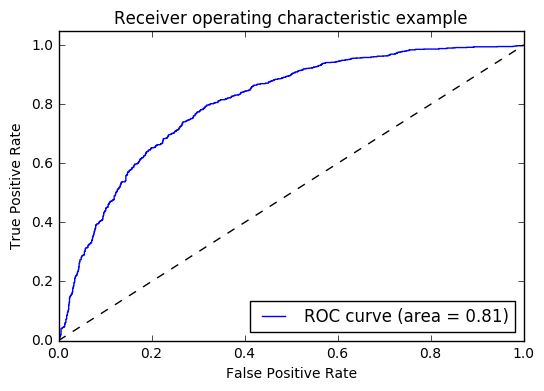

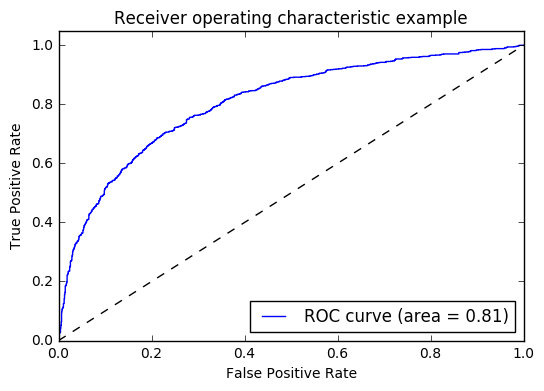

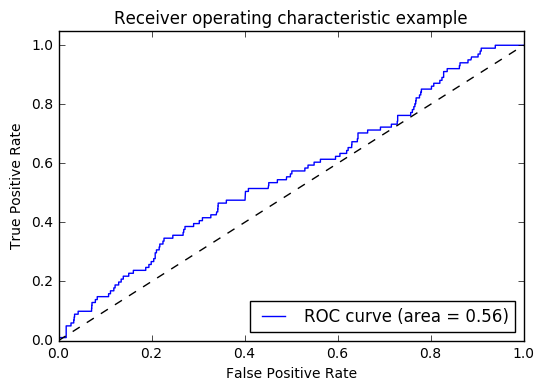

In [32]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.cross_validation import train_test_split

#Show ROC curves to help choose classification thresholds

y = label_binarize(y, classes=[0,1,2])
n_classes = 3

# shuffle and split training and test sets
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.33, random_state=0)

# classifier, use one v rest because there are more than 2 classes
OVRclf = OneVsRestClassifier(LinearSVC(random_state=0))
y_score = OVRclf.fit(xtrain, ytrain).decision_function(xtest)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ytest[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

#Random forest
#logreg and RF seem to be superior as of now

clf_RF = RandomForestClassifier(max_depth=2, random_state=0)
clf_RF.fit(xtrain, ytrain)
y_pred_classRF = clf_RF.predict(xtest)
# calculate accuracy
print(metrics.accuracy_score(ytest, y_pred_classRF))

0.6856649395509499


In [34]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(xtrain)

#scale training data
NNxtrain = scaler.transform(xtrain)  
NNxtest = scaler.transform(xtest) 

from sklearn.neural_network import MLPClassifier  
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)  
mlp.fit(NNxtrain, ytrain)

y_pred_classNN = mlp.predict(NNxtest) 

In [35]:
print(metrics.accuracy_score(ytest, y_pred_classNN))

0.697754749568221
